# <a id='env'>1. Setting up the Environment</a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [4]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 140MB/s]


In [5]:
!ls

brain-mri-images-for-brain-tumor-detection.zip	kaggle.json
brain_tumor_dataset_samples			kereas_pretrained_model


In [6]:
!unzip \*.zip  && rm *.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

In [7]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt

import imutils    
import time

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



from keras.applications.xception import Xception,preprocess_input
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3

%matplotlib inline



In [8]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

# <a id='import'>2. Data Import and Preprocessing</a>

In [9]:
image_dir="../Kaggle/brain_tumor_dataset/"
image_dir_samples="../Kaggle/brain_tumor_dataset_samples/"

In [10]:
os.makedirs('../output/kaggle/working/augmented-images', exist_ok = True)
os.makedirs('../output/kaggle/working/augmented-images/yes', exist_ok = True)
os.makedirs('../output/kaggle/working/augmented-images/no', exist_ok = True)
os.makedirs('../output/kaggle/working/augmented-images_samples/yes', exist_ok = True)
os.makedirs('../output/kaggle/working/augmented-images_samples/no', exist_ok = True)

augmented_data_path ='../output/kaggle/working/augmented-images/'
augmented_data_path_samples ='../output/kaggle/working/augmented-images_samples/'
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_SIZE = (224,224)

In [11]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [12]:
dir = os.listdir('../output/kaggle/working/augmented-images_samples/yes') 
start_time = time.time()

if len(dir) == 0: 
    augment_data(file_dir=image_dir_samples+'yes',n_generated_samples=30, save_to_dir=augmented_data_path_samples+'yes')
    augment_data(file_dir=image_dir_samples+'no', n_generated_samples=30, save_to_dir=augmented_data_path_samples+'no')
else:
    print(len(dir))
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:0:2.4


In [13]:
def load_data(dir_list):
    X = []
    y = []
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            X.append(image)

            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [14]:
def plot_samples(X, y, labels_dict, n=50):
    flag=0
    for index in range(0,len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
      
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        if flag==0:
          plt.suptitle('Tumor :No')
        else:
           plt.suptitle('Tumor :Yes')
        flag+=1
        plt.show()

In [15]:
X_train_sample, y_train_sample = load_data([augmented_data_path_samples+'yes', augmented_data_path_samples+'no'])

Number of examples is: 62
X shape is: (62, 225, 225, 3)
y shape is: (62, 1)


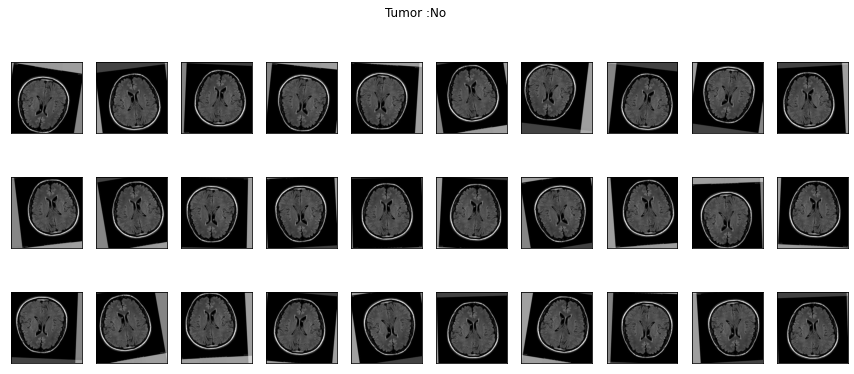

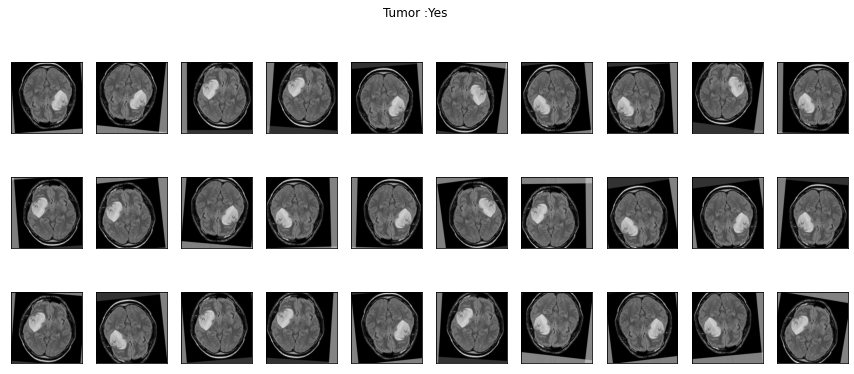

In [16]:
plot_samples(X_train_sample, y_train_sample, ['yes','no'], 30)

In [17]:
dir = os.listdir('../output/kaggle/working/augmented-images/yes') 
start_time = time.time()

if len(dir) == 0: 
    augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
    augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')
else:
    print(len(dir))
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Elapsed time: 0:1:47.5


In [18]:
def data_summary():    
    m_pos = len(listdir(augmented_yes))
    m_neg = len(listdir(augmented_no))
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 

In [19]:
data_summary()

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [20]:

X_train, y_train = load_data([augmented_yes, augmented_no])

Number of examples is: 2065
X shape is: (2065,)
y shape is: (2065, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


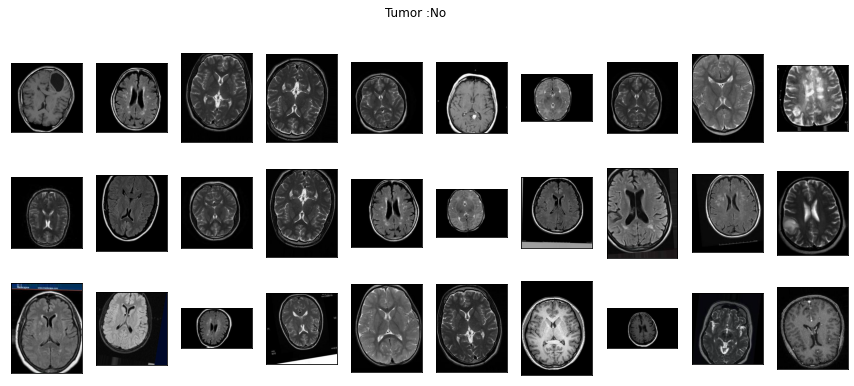

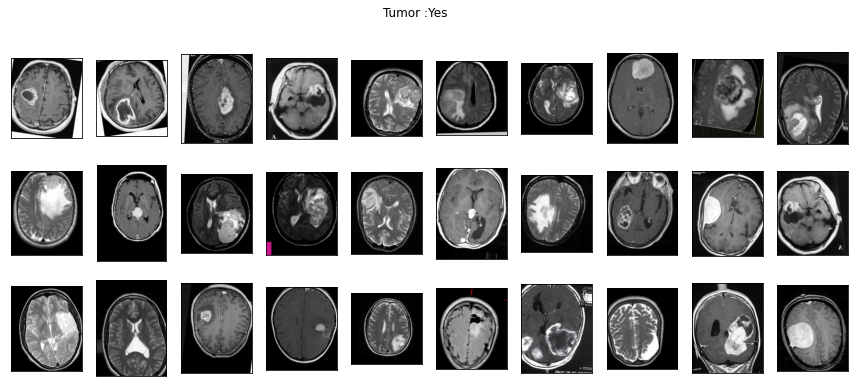

In [21]:
plot_samples(X_train, y_train, ['yes','no'], 30)

In [22]:
def crop_brain_contour(image, plot=False):
    
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

   
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [23]:
img = cv2.imread('../Kaggle/brain_tumor_dataset/yes/Y9.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)


thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)


cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)


extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])


img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)


img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)


ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

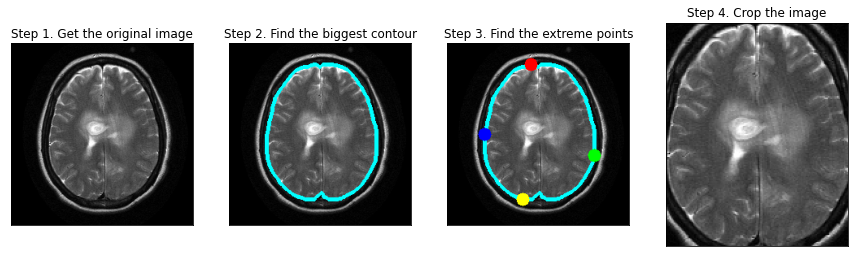

In [24]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [25]:
def Croping_Data(train):

    X = []
    y = []
    
    for img in train:
        image = crop_brain_contour(img, plot=False)
        X.append(image)
                
    X = np.array(X)
    
    return X

In [26]:
X = Croping_Data(X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


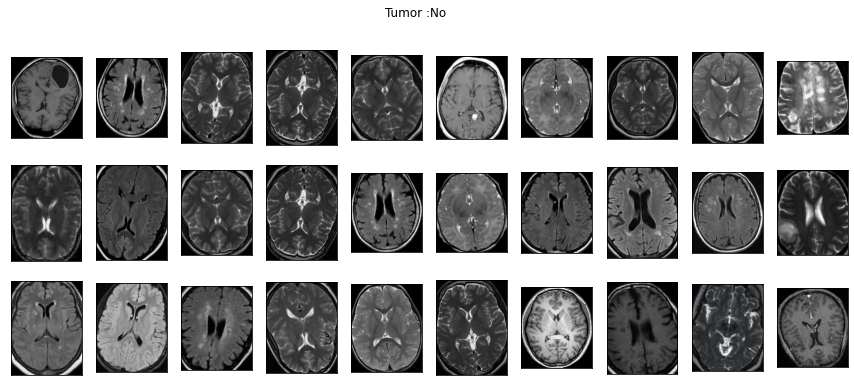

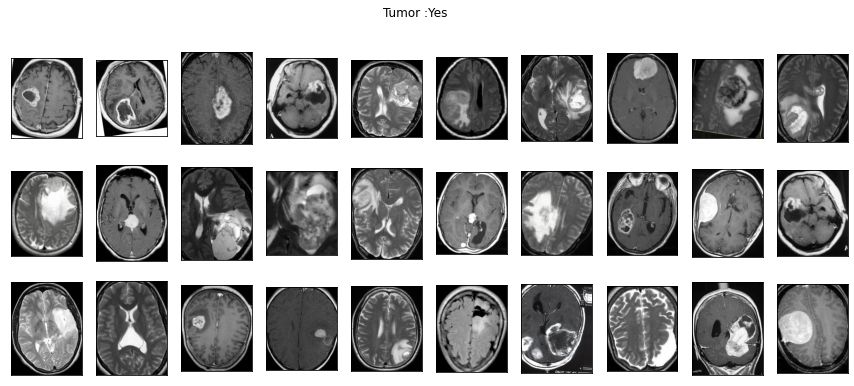

In [27]:
plot_samples(X, y_train, ['yes','no'], 30)

In [28]:
def Resize_Data(train):

    X = []
    y = []
    
    IMG_WIDTH, IMG_HEIGHT = (240, 240)
    
    for img in train:
        image = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        
        image = image / 255.
    
        X.append(image)
                
    X = np.array(X)
    
    return X

In [29]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X = Resize_Data(X)
y = y_train



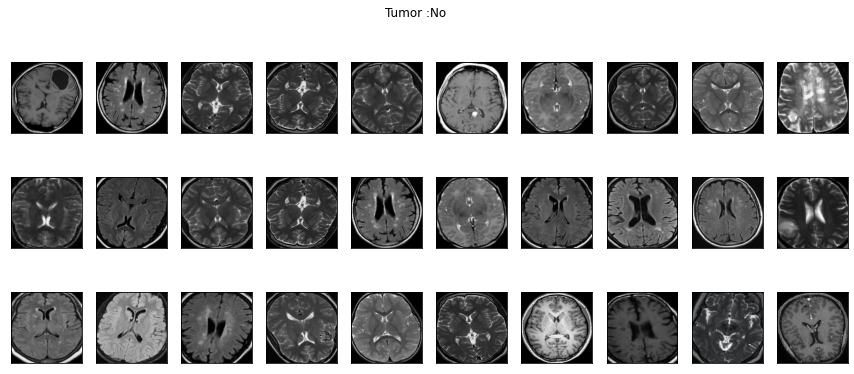

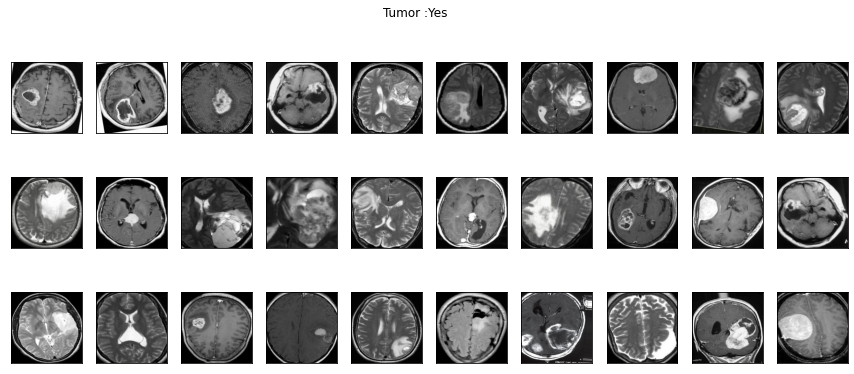

In [30]:
plot_samples(X, y_train, ['yes','no'],30)

## Visualization of data

In [31]:
def split_data(X, y, test_size=0.3):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [32]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [33]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1445
number of validation examples = 310
number of test examples = 310


In [34]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [35]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.11072664359862%, number of pos examples: 753
Percentage of negative examples: 47.88927335640138%, number of neg examples: 692
Validation Data:
Number of examples: 310
Percentage of positive examples: 50.96774193548387%, number of pos examples: 158
Percentage of negative examples: 49.03225806451613%, number of neg examples: 152
Testing Data:
Number of examples: 310
Percentage of positive examples: 56.12903225806452%, number of pos examples: 174
Percentage of negative examples: 43.87096774193548%, number of neg examples: 136


In [36]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

## <a id='build'>4. MODEL BUILDING</a>

## 4.1. MODEL WITHOUT VGG-16 (MODEL FROM BASE)

In [37]:
def build_model(input_shape):
  
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    
    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    print(model)
    
    return model

In [38]:
IMG_SHAPE=(240,240,3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0     

In [39]:

def compute_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    precision=precision_score(y_true, y_pred)
    recall=recall_score(y_true, y_pred)
    score = f1_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    print("confusion matrix:\n")
    print(matrix)
    tp, fn, fp, tn = matrix.ravel()
    print(f"\n\nValue of true positive:{tp}")
    print(f"Value of false negative:{fn}")
    print(f"Value of false positive:{fp}")
    print(f"Value of true negative:{tn}")
    tpr=tp/(tp+fn)
    fnr=fn/(tp+fn)
    tnr=tn/(fp+tn)
    fpr=fp/(fp+tn)
    print("\n\nRates=>\n")
    print(f"True positive Rate:{tpr}")
    print(f"False Negative Rate:{fnr}")
    print(f"False positive Rate:{tnr}")
    print(f"True negative Rate:{fpr}\n\n")

    
    return score,recall,precision

In [40]:

labels = ['yes','no']

In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [43]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val), callbacks=[tensorboard])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/25
46/46 [==============================] - 36s 106ms/step - loss: 0.6942 - accuracy: 0.6720 - val_loss: 0.6428 - val_accuracy: 0.6935
Epoch 2/25
46/46 [==============================] - 3s 58ms/step - loss: 0.5108 - accuracy: 0.7571 - val_loss: 0.6010 - val_accuracy: 0.7742
Epoch 3/25
46/46 [==============================] - 3s 58ms/step - loss: 0.4459 - accuracy: 0.7945 - val_loss: 0.5685 - val_accuracy: 0.7516
Epoch 4/25
46/46 [==============================] - 3s 60ms/step - loss: 0.3491 - accuracy: 0.8498 - val_loss: 0.5307 - val_accuracy: 0.7677
Epoch 5/25
46/46 [==============================] - 3s 58ms/step - loss: 0.3314 - accuracy: 0.8623 - val_loss: 0.4784 - val_accuracy: 0.8065
Epoch 6/25
46/46 [==============================] - 3s 58ms/step - loss: 0.2860 - accuracy: 0.8803 - val_loss: 0.4844 - val_accuracy: 0.7419
Epoch 7/25
46/46 [==============================] - 3s 59ms/step - loss: 0.2952 - accuracy: 0.8789 - val_loss: 0.4353 - val_accuracy: 0.7806
Epoch 8/25


In [44]:
history = model.history.history

In [45]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

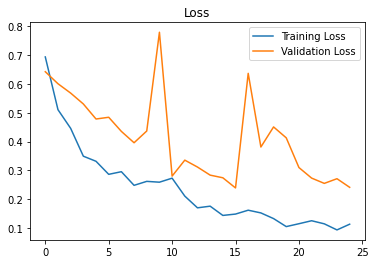

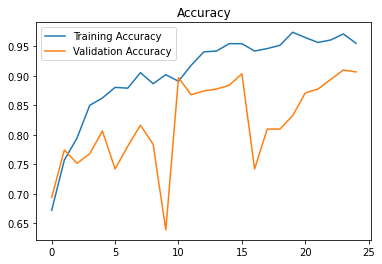

In [46]:
plot_metrics(history)

In [47]:
model.metrics_names

['loss', 'accuracy']

In [48]:
loss_t, acc_t = model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 0s 27ms/step - loss: 0.3651 - accuracy: 0.8806


In [49]:
print (f"Test Loss = {loss_t}")
print (f"Test Accuracy = {acc_t}")

Test Loss = 0.3650815784931183
Test Accuracy = 0.8806451559066772


In [50]:
y_test_prob = model.predict(X_test)

In [51]:
print("test set of Model without transfer learning")
f1score_val,recall,precision = compute_score(y_test, y_test_prob)
print(f"validation F1 score: {f1score_val}")
print(f"validation Precision score:{precision}")
print(f"validation Recall:{recall}")



test set of Model without transfer learning
confusion matrix:

[[124  12]
 [ 25 149]]


Value of true positive:124
Value of false negative:12
Value of false positive:25
Value of true negative:149


Rates=>

True positive Rate:0.9117647058823529
False Negative Rate:0.08823529411764706
False positive Rate:0.8563218390804598
True negative Rate:0.14367816091954022


validation F1 score: 0.8895522388059701
validation Precision score:0.9254658385093167
validation Recall:0.8563218390804598


In [52]:
loss_v, acc_v = model.evaluate(x=X_val, y=y_val)
print (f"validation Loss = {loss_v}")
print (f"validation Accuracy = {acc_v}")

10/10 [==============================] - 0s 26ms/step - loss: 0.2409 - accuracy: 0.9065
validation Loss = 0.24085840582847595
validation Accuracy = 0.9064516425132751


In [53]:
y_val_prob = model.predict(X_val)

In [54]:
print("Validation of Model without transfer learning")
f1score_val,recall,precision = compute_score(y_val, y_val_prob)
print(f"validation F1 score: {f1score_val}")
print(f"validation Precision score:{precision}")
print(f"validation Recall:{recall}")



Validation of Model without transfer learning
confusion matrix:

[[137  15]
 [ 14 144]]


Value of true positive:137
Value of false negative:15
Value of false positive:14
Value of true negative:144


Rates=>

True positive Rate:0.9013157894736842
False Negative Rate:0.09868421052631579
False positive Rate:0.9113924050632911
True negative Rate:0.08860759493670886


validation F1 score: 0.9085173501577287
validation Precision score:0.9056603773584906
validation Recall:0.9113924050632911


In [55]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.11072664359862%, number of pos examples: 753
Percentage of negative examples: 47.88927335640138%, number of neg examples: 692
Validation Data:
Number of examples: 310
Percentage of positive examples: 50.96774193548387%, number of pos examples: 158
Percentage of negative examples: 49.03225806451613%, number of neg examples: 152
Testing Data:
Number of examples: 310
Percentage of positive examples: 56.12903225806452%, number of pos examples: 174
Percentage of negative examples: 43.87096774193548%, number of neg examples: 136


### 4.2 MODEL WITH VGG-16

In [56]:


from sklearn.model_selection import KFold
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
vgg16_weight_path = '../Kaggle/kereas_pretrained_model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_model = VGG16(weights=vgg16_weight_path,include_top=False, input_shape=IMG_SHAPE)


In [57]:
NUM_CLASSES = 1

model1= Sequential()
model1.add(vgg16_model)
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model1.layers[0].trainable = False

model1.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model1.summary()


model1.layers[0].trainable = False


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [58]:
start_time = time.time()

model1.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[tensorboard])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/30
46/46 [==============================] - 40s 444ms/step - loss: 0.7427 - accuracy: 0.5393 - val_loss: 0.5673 - val_accuracy: 0.7258
Epoch 2/30
46/46 [==============================] - 9s 200ms/step - loss: 0.6016 - accuracy: 0.6673 - val_loss: 0.4823 - val_accuracy: 0.8129
Epoch 3/30
46/46 [==============================] - 8s 181ms/step - loss: 0.5487 - accuracy: 0.7034 - val_loss: 0.4552 - val_accuracy: 0.8129
Epoch 4/30
46/46 [==============================] - 8s 179ms/step - loss: 0.4774 - accuracy: 0.7622 - val_loss: 0.4452 - val_accuracy: 0.8000
Epoch 5/30
46/46 [==============================] - 8s 181ms/step - loss: 0.4275 - accuracy: 0.8196 - val_loss: 0.3749 - val_accuracy: 0.8645
Epoch 6/30
46/46 [==============================] - 9s 207ms/step - loss: 0.3964 - accuracy: 0.8415 - val_loss: 0.3656 - val_accuracy: 0.8677
Epoch 7/30
46/46 [==============================] - 10s 208ms/step - loss: 0.3666 - accuracy: 0.8455 - val_loss: 0.3444 - val_accuracy: 0.8774
Epoc

In [59]:
history1 = model1.history.history

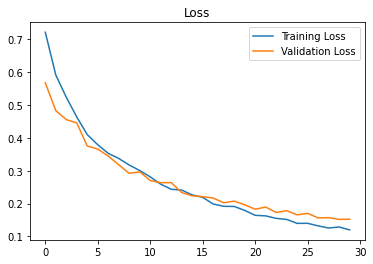

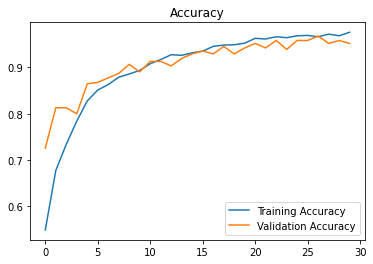

In [60]:
plot_metrics(history1)

In [61]:
model1.metrics_names

['loss', 'accuracy']

In [62]:
loss_t_1, acc_t_1 = model1.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 2s 156ms/step - loss: 0.1938 - accuracy: 0.9226


In [63]:
print (f"Test Loss = {loss_t_1}")
print (f"Test Accuracy = {acc_t_1}")


Test Loss = 0.19384554028511047
Test Accuracy = 0.9225806593894958


In [64]:
y_test_prob_1= model1.predict(X_test)


In [65]:
print("test set of Model with Vgg-16")
f1score_val,recall,precision = compute_score(y_test, y_test_prob_1)
print(f"validation F1 score: {f1score_val}")
print(f"validation Precision score:{precision}")
print(f"validation Recall:{recall}")

test set of Model with Vgg-16
confusion matrix:

[[136   0]
 [ 24 150]]


Value of true positive:136
Value of false negative:0
Value of false positive:24
Value of true negative:150


Rates=>

True positive Rate:1.0
False Negative Rate:0.0
False positive Rate:0.8620689655172413
True negative Rate:0.13793103448275862


validation F1 score: 0.9259259259259259
validation Precision score:1.0
validation Recall:0.8620689655172413


In [66]:
loss_v_1, acc_v_1 = model1.evaluate(x=X_val, y=y_val)
print (f"validation Loss = {loss_v_1}")
print (f"validation Accuracy = {acc_v_1}")

10/10 [==============================] - 2s 158ms/step - loss: 0.1524 - accuracy: 0.9516
validation Loss = 0.15244993567466736
validation Accuracy = 0.9516128897666931


In [67]:
y_val_prob_1 = model1.predict(X_val)

In [68]:
print("Validation set of Model with Vgg-16")
f1score_val,recall,precision = compute_score(y_val, y_val_prob_1)
print(f"validation F1 score: {f1score_val}")
print(f"validation Precision score:{precision}")
print(f"validation Recall:{recall}")

Validation set of Model with Vgg-16
confusion matrix:

[[150   2]
 [ 13 145]]


Value of true positive:150
Value of false negative:2
Value of false positive:13
Value of true negative:145


Rates=>

True positive Rate:0.9868421052631579
False Negative Rate:0.013157894736842105
False positive Rate:0.9177215189873418
True negative Rate:0.08227848101265822


validation F1 score: 0.9508196721311475
validation Precision score:0.9863945578231292
validation Recall:0.9177215189873418


### 4.3. InceptionV3

In [69]:
InceptionV3_weight_path = '../Kaggle/kereas_pretrained_model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionV3 = InceptionV3(
     weights=InceptionV3_weight_path,
    include_top=False, 
    input_shape=IMG_SHAPE
)


In [70]:
NUM_CLASSES = 1

model2 = Sequential()
model2.add(inceptionV3)
model2.add(layers.Dropout(0.3))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model2.layers[0].trainable = False

model2.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 73728)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 73729     
Total params: 21,876,513
Trainable params: 73,729
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [71]:
start_time = time.time()

model2.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[tensorboard])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/20
46/46 [==============================] - 35s 342ms/step - loss: 0.8866 - accuracy: 0.6418 - val_loss: 0.2732 - val_accuracy: 0.8968
Epoch 2/20
46/46 [==============================] - 5s 104ms/step - loss: 0.3449 - accuracy: 0.8403 - val_loss: 0.1996 - val_accuracy: 0.9290
Epoch 3/20
46/46 [==============================] - 5s 115ms/step - loss: 0.2558 - accuracy: 0.9032 - val_loss: 0.1560 - val_accuracy: 0.9548
Epoch 4/20
46/46 [==============================] - 5s 105ms/step - loss: 0.2135 - accuracy: 0.9227 - val_loss: 0.1416 - val_accuracy: 0.9548
Epoch 5/20
46/46 [==============================] - 5s 115ms/step - loss: 0.1176 - accuracy: 0.9545 - val_loss: 0.1422 - val_accuracy: 0.9452
Epoch 6/20
46/46 [==============================] - 5s 105ms/step - loss: 0.1326 - accuracy: 0.9467 - val_loss: 0.1105 - val_accuracy: 0.9677
Epoch 7/20
46/46 [==============================] - 5s 115ms/step - loss: 0.1061 - accuracy: 0.9620 - val_loss: 0.1123 - val_accuracy: 0.9645
Epoch

In [72]:
history2 = model2.history.history

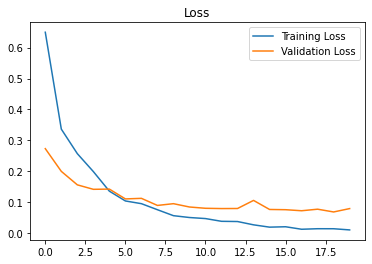

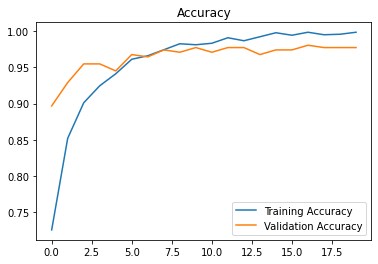

In [73]:
plot_metrics(history2)

In [74]:
model2.metrics_names

['loss', 'accuracy']

In [75]:
loss_t_2, acc_t_2 = model2.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 1s 85ms/step - loss: 0.0562 - accuracy: 0.9871


In [76]:
print (f"Test Loss = {loss_t_2}")
print (f"Test Accuracy = {acc_t_2}")

Test Loss = 0.05615023151040077
Test Accuracy = 0.9870967864990234


In [77]:
y_test_prob_2 = model2.predict(X_test)

In [78]:
print("test set of Model with  InceptionV3")
f1score_val,recall,precision = compute_score(y_test, y_test_prob_2)
print(f"validation F1 score: {f1score_val}")
print(f"validation Precision score:{precision}")
print(f"validation Recall:{recall}")

test set of Model with  InceptionV3
confusion matrix:

[[133   3]
 [  1 173]]


Value of true positive:133
Value of false negative:3
Value of false positive:1
Value of true negative:173


Rates=>

True positive Rate:0.9779411764705882
False Negative Rate:0.022058823529411766
False positive Rate:0.9942528735632183
True negative Rate:0.005747126436781609


validation F1 score: 0.9885714285714285
validation Precision score:0.9829545454545454
validation Recall:0.9942528735632183


In [79]:
loss_v_2, acc_v_2 = model2.evaluate(x=X_val, y=y_val)
print (f"validation Loss = {loss_v_2}")
print (f"validation Accuracy = {acc_v_2}")

10/10 [==============================] - 1s 83ms/step - loss: 0.0792 - accuracy: 0.9774
validation Loss = 0.07920516282320023
validation Accuracy = 0.977419376373291


In [80]:
y_val_prob_2 = model2.predict(X_val)


In [81]:
print("Validation set of Model with InceptionV3")
f1score_val,recall,precision = compute_score(y_val, y_val_prob_2)
print(f"validation F1 score: {f1score_val}")
print(f"validation Precision score:{precision}")
print(f"validation Recall:{recall}")

Validation set of Model with InceptionV3
confusion matrix:

[[146   6]
 [  1 157]]


Value of true positive:146
Value of false negative:6
Value of false positive:1
Value of true negative:157


Rates=>

True positive Rate:0.9605263157894737
False Negative Rate:0.039473684210526314
False positive Rate:0.9936708860759493
True negative Rate:0.006329113924050633


validation F1 score: 0.9781931464174455
validation Precision score:0.9631901840490797
validation Recall:0.9936708860759493


In [82]:
os.makedirs('../output/Model', exist_ok = True)

In [83]:
%cd /content/gdrive/My Drive/output/Model

/content/gdrive/My Drive/output/Model


In [84]:
model.save('model_without_Transfer_learning.h5')
model1.save('Final_VGG_model.h5')
model2.save("Final_InceptionV3.h5")

## THE END...